# Import libraries

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.cluster.hierarchy as hc
import scipy.spatial as sp

In [2]:
MAIN_DIR = Path('.').absolute().parent
sys.path.append(str(MAIN_DIR))
from dynosarc import utils as utl

# Directories and file names

In [3]:
DATA_DIR = MAIN_DIR / 'data'
RESULTS_DIR = MAIN_DIR / 'results'

In [4]:
SUBTYPES_FNAME = DATA_DIR / 'subtypes.csv'  

RNA_HPRD_FNAME = DATA_DIR / 'rna_hprd.csv'  
E_HPRD_FNAME = DATA_DIR / 'edgelist_hprd.csv' 
E_HPRD_ONCOKB_FNAME = DATA_DIR / 'edgelist_hprd_oncokb.csv' 

In [5]:
CLUS_RESULTS_DIR = RESULTS_DIR / 'clus_results'

if not CLUS_RESULTS_DIR.is_dir():
    CLUS_RESULTS_DIR.mkdir()    

# Load data

In [6]:
subtypes = pd.read_csv(SUBTYPES_FNAME, header=0, index_col=0)
subtypes = subtypes['subtype']

In [7]:
E = pd.read_csv(E_HPRD_FNAME, header=0, index_col=None)
G = nx.from_pandas_edgelist(E)

In [8]:
data = pd.read_csv(RNA_HPRD_FNAME, header=0, index_col=0)

# Wasserstein-based hierarchical clustering

## Compute invariant distributions

Invariant distributions are computed if a file with the invariant distribution file name doesn't exist. Otherwise, the invariant distributions are loaded from the file.

In [9]:
invr_fname = CLUS_RESULTS_DIR / 'invariant_distributions_hprd.csv'

In [10]:
invrs = utl.compute_invariant_measures_for_cohort(G, data, invr_fname)

## Compute pairwise Wasserstein distances between invariant distributions

The 1-Wasserstein distance is commonly called the earth mover's distance (EMD). We therefore use Wasserstein distance and EMD interchangeably. 

The pairwise EMDs are computed if a file with the pairwise EMD matrix file name doesn't exist. Otherwise, the pairwise EMDs are loaded from the file.

In [11]:
emds_fname = CLUS_RESULTS_DIR / 'emds_invariant_distributions_hprd.csv'

In [12]:
emds = utl.EMD_matrix(invrs, G, emds_fname)

## Hierarchical clustering

Check that the rows and columns of the emds dataframe is ordered symmetrically:

In [13]:
np.all(emds.index == emds.columns)

True

In [14]:
emds_linkage = hc.linkage(sp.distance.squareform(emds), method='ward')

First, we plot the dendrogram to visualize the clustering:

In [15]:
lut = {'DSRCT': 'darkblue', 'Ewing Sarcoma': 'darkgreen', 'Osteosarcoma': 'orange', 'Embryonal RMS': 'purple'}
subtype_colors = subtypes.replace(lut).to_frame(name='Subtype')

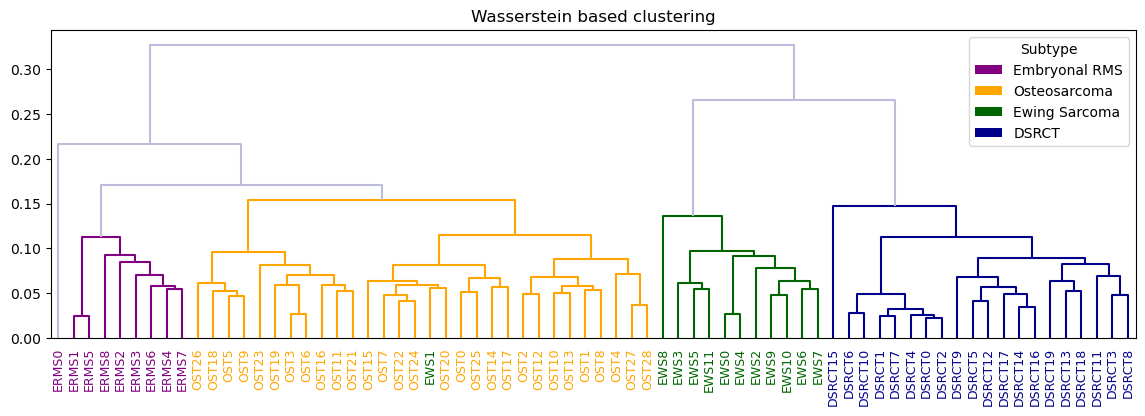

In [16]:
f, ax = plt.subplots(1, 1, figsize=(14, 4))

hc.set_link_color_palette(['purple', 'orange', 'darkgreen', 'darkblue']) 
hlt = hc.dendrogram(emds_linkage, above_threshold_color='#bcbddc', orientation='top', labels=emds.columns.tolist()[:],
                    color_threshold=0.165, distance_sort='ascending', leaf_font_size=9, leaf_rotation=90, ax=ax)

hc.set_link_color_palette(None)  # reset to default after use                                                                                    
plt.title("Wasserstein based clustering")
# Apply the right color to each label                                                                                                            
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    ll = lbl.get_text()
    if subtypes[ll] == 'DSRCT':
        lbl.set_color('darkblue')
    elif subtypes[ll] == 'Osteosarcoma':
        lbl.set_color('orange')
    elif subtypes[ll] == 'Ewing Sarcoma':
        lbl.set_color('darkgreen')
    elif subtypes[ll] == 'Embryonal RMS':
        lbl.set_color('purple')
    else:
        raise ValueError("Unrecognized subtype.")
        
for label in ['Embryonal RMS','Osteosarcoma','Ewing Sarcoma','DSRCT']:
     ax.bar(0, 0, color=lut[label], label=label, linewidth=0)

ax.legend(title='Subtype');

In [17]:
sample_ordering = [emds.index.tolist()[k] for k in hlt['leaves']]

Subtypes found by Wasserstein-based hierarchical clustering with pre-set 4 clusters (and 1 outlier):

In [18]:
clustering_fname = CLUS_RESULTS_DIR / 'clustering_invariant_distributions_hprd.csv'

In [19]:
if not clustering_fname.is_file(): # compute partition
    wass_clustering = pd.Series(data=hc.fcluster(emds_linkage, 5, criterion='maxclust'), index=emds.index.copy(), name='Wasserstein_hclust')
    
    # Replace cluster index with subtype:
    wass_clustering = wass_clustering.replace({1: 'Embryonal RMS', 2: 'Osteosarcoma', 3: 'Outlier', 4: 'Ewing Sarcoma', 5: 'DSRCT'})
    
    # Save clustering in ordering by dendrogram:
    wass_clustering = wass_clustering.loc[sample_ordering]
    
    # Save clustering:
    wass_clustering.to_csv(clustering_fname, header=True, index=True)
else: # load partition: 
    wass_clustering = pd.read_csv(clustering_fname, header=0, index_col=0)['Wasserstein_hclust']

Dendrogram with heatmap of Wasserstein distances visualization:

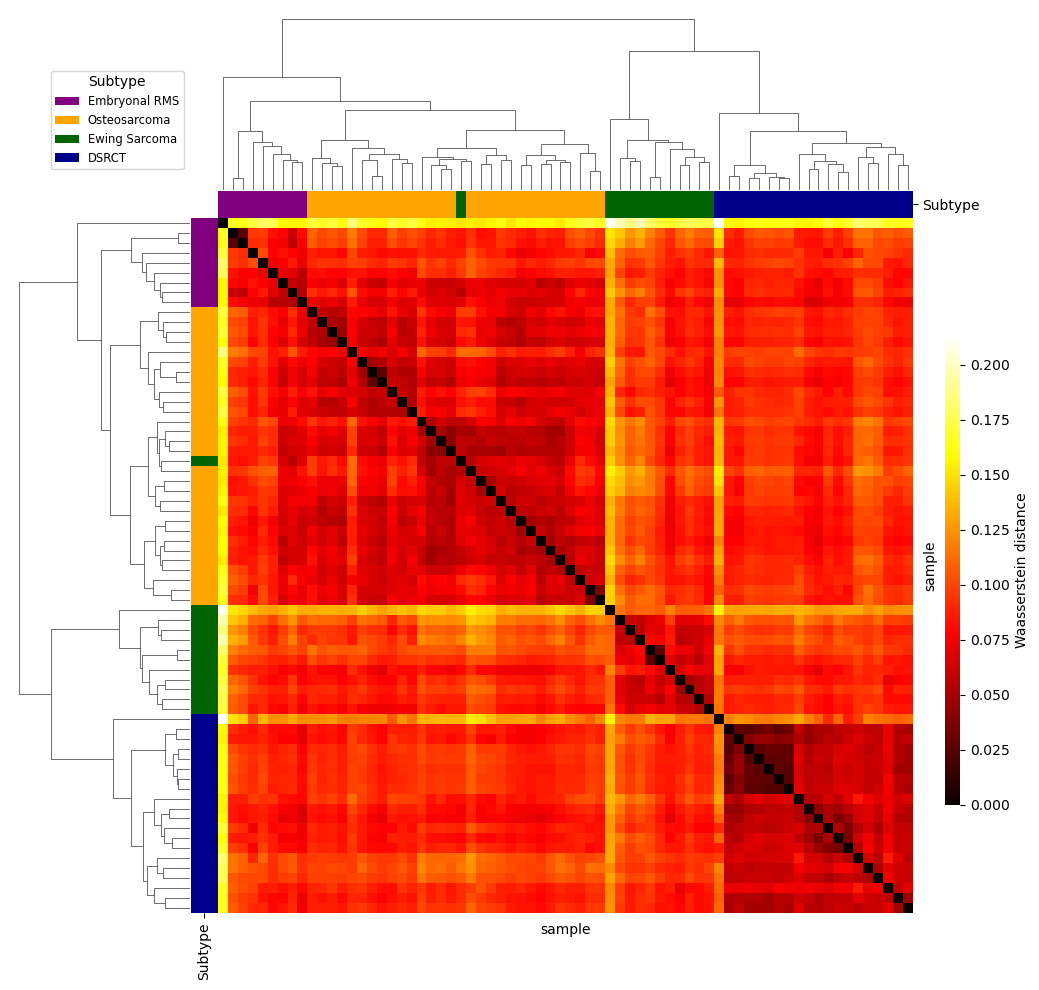

In [20]:
g = sns.clustermap(emds, row_linkage=emds_linkage, col_linkage=emds_linkage, figsize=(10,10), 
                   yticklabels=False, xticklabels=False, row_colors=subtype_colors, col_colors=subtype_colors,
                   cmap="hot", # linewidths=0.05,linecolor="white",
                   cbar_pos=(0.95,0.19,0.015,0.47), cbar_kws={'label': 'Waasserstein distance'})
for label in ['Embryonal RMS','Osteosarcoma','Ewing Sarcoma','DSRCT']:
     g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(title="Subtype",loc="upper left", ncol=1,bbox_to_anchor=(0.05, 0.93), bbox_transform=plt.gcf().transFigure,fontsize='small')
g.ax_heatmap.set_xlabel('sample');
g.ax_heatmap.set_ylabel('sample');
# g.figure.savefig(MAIN_DIR / 'figures' / 'Wass_subtype_clustering_heatmap.png', dpi=300, bbox_inches='tight')

In [187]:
silh_scores_wo_outlier = {}
for n_clus in range(2, EMDs_wo_outlier.shape[0]+1):
    predicted_labels = hc.fcluster(linkage_wo_outlier, n_clus, criterion='maxclust')
    silh_scores_wo_outlier[n_clus] = silhouette_score(EMDs_wo_outlier.copy(), predicted_labels, metric="precomputed")
    
silh_scores_wo_outlier = pd.Series(silh_scores_wo_outlier)    

In [188]:
silh_wo_outlier_opt_n_clus = silh_scores_wo_outlier.idxmax()
print(f"Optimal Silhouette score w/o outlier = {silh_scores_wo_outlier[silh_wo_outlier_opt_n_clus]} with {silh_wo_outlier_opt_n_clus} clusters")
silh_wo_outlier_predicted_labels = pd.Series(data=hc.fcluster(linkage_wo_outlier, silh_wo_outlier_opt_n_clus, criterion='maxclust'), index=EMDs_wo_outlier.index.copy(), name='Silhouette_score')

Optimal Silhouette score w/o outlier = 0.24025750246139804 with 3 clusters
